Performs data augmentation by mirroring (flipping), shifting (left, right, d, t), differentiating (right, down)

In [37]:
import numpy as np
import pandas as pd
import scipy
from numpy import linalg
import cvxopt
from cvxopt import solvers, matrix
from scipy.spatial.distance import pdist, cdist, squareform

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


In [38]:
%%time
df_X_train = pd.read_csv('Xtr.csv', header=None, usecols=np.arange(3072))
df_X_test = pd.read_csv('Xte.csv', header=None, usecols=np.arange(3072))
df_y_train = pd.read_csv('Ytr.csv')


X_train = np.array(df_X_train, dtype=float)
X_test = np.array(df_X_test, dtype=float)
y_train = np.array(df_y_train['Prediction'], dtype=float)

CPU times: user 4.78 s, sys: 124 ms, total: 4.91 s
Wall time: 4.97 s


In [39]:
# Data Visualization : The Data set train is balance, OVA can be implemented
classes = np.unique(y_train)
for class_ in classes:
    print(class_, np.mean(class_ == y_train))

0.0 0.1
1.0 0.1
2.0 0.1
3.0 0.1
4.0 0.1
5.0 0.1
6.0 0.1
7.0 0.1
8.0 0.1
9.0 0.1


In [40]:
def rgb2gray(rgb, reshape = True):
    # if reshape is true, array is reshape in 32.32 pixels
    n = rgb.shape[0]
    r = rgb[:,:1024]
    g = rgb[:,1024:2048]
    b = rgb[:,2048:]
    gray = 0.299*r + 0.587*g + 0.114*b
    # from matlab 0.2989 * R + 0.5870 * G + 0.1140 * B
    if reshape is True:
        gray = gray.reshape(n, 32,32)
    return gray


In [41]:
def plot(X, lim=4):
    n = X.shape[0]
    for kk in range(n):
        if kk>lim:
            break
        plt.imshow(X[kk], cmap='gray')
        plt.show()

### Data augmentation

* We perform 4 rot90 and transpose every time so it will lead to 20K images

In [42]:
def shift_right(X):
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    shifted = np.zeros_like(X) # Will contain the shifted RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        temp = col[:,:,0]
        shifted_col = np.roll(col, axis=2, shift=1)
        shifted_col[:,:,0]= temp
        shifted_col = shifted_col.reshape(n,-1)

        shifted[:, 1024*kk:1024*(kk+1)] = shifted_col
    
    return shifted

def shift_left(X):
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    shifted = np.zeros_like(X) # Will contain the shifted RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        temp = col[:,:,-1]
        shifted_col = np.roll(col, axis=2, shift=-1)
        shifted_col[:,:,-1]= temp
        shifted_col = shifted_col.reshape(n,-1)

        shifted[:, 1024*kk:1024*(kk+1)] = shifted_col
    
    return shifted

def shift_up(X):
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    shifted = np.zeros_like(X) # Will contain the shifted RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        temp = col[:,-1,:]
        shifted_col = np.roll(col, axis=1, shift=-1)
        shifted_col[:,-1,:]= temp
        shifted_col = shifted_col.reshape(n,-1)

        shifted[:, 1024*kk:1024*(kk+1)] = shifted_col
    
    return shifted

def shift_down(X):
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    shifted = np.zeros_like(X) # Will contain the shifted RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        temp = col[:,0,:]
        shifted_col = np.roll(col, axis=1, shift=1)
        shifted_col[:,0,:]= temp
        shifted_col = shifted_col.reshape(n,-1)

        shifted[:, 1024*kk:1024*(kk+1)] = shifted_col
    
    return shifted

In [43]:
def differentiate_right(X):
    
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    diff = np.zeros_like(X) # Will contain the differentiate RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        diff_col = np.zeros_like(col)
        temp = col[:,:,0]
        diff_col[:,:,1:] = np.diff(col, axis=2) #np.roll(col, axis=2, shift=1)
        diff_col[:,:,0]= temp
        diff_col = diff_col.reshape(n,-1)
        diff[:, 1024*kk:1024*(kk+1)] = diff_col
    
    return diff

In [44]:
def differentiate_down(X):
    
    n, p = X.shape
    
    X_r = X[:,:1024].reshape(n, 32, 32)
    X_g = X[:,1024:2048].reshape(n, 32, 32)
    X_b = X[:,2048:].reshape(n, 32, 32)    
    diff = np.zeros_like(X) # Will contain the differentiate RGB
    colors = [X_r, X_g, X_b]
    for kk, col in enumerate(colors):
        diff_col = np.zeros_like(col)
        temp = col[:,0,]
        diff_col[:,1:,:] = np.diff(col, axis=1) #np.roll(col, axis=2, shift=1)
        diff_col[:,0,:]= temp
        diff_col = diff_col.reshape(n,-1)
        diff[:, 1024*kk:1024*(kk+1)] = diff_col
    
    return diff

In [45]:
def differentiate_left(X):
    X = flip_lr(X)
    X = differentiate_right(X)
    X = flip_lr(X)
    return X

def differentiate_up(X):
    X = flip_ud(X)
    X = differentiate_down(X)
    X = flip_ud(X)
    return X
    

In [46]:
def flip_lr(X):
    # Augmentation by flipping (transpose)
    n, p = X.shape
    X_res = np.zeros((n, p)) # FLipped images are assigned here
    X_r = X[:,:1024]
    X_g = X[:,1024:2048]
    X_b = X[:,2048:]
    
    for kk in range(n):
        x_r = np.fliplr(X_r[kk].reshape(32,32)).ravel()
        x_g = np.fliplr(X_b[kk].reshape(32,32)).ravel()
        x_b = np.fliplr(X_g[kk].reshape(32,32)).ravel()
        new_sample = np.r_[x_r, x_g, x_b].reshape(1,-1)
        X_res[kk] = new_sample
    
    return X_res

def flip_ud(X):
    # Augmentation by flipping (transpose)
    n, p = X.shape
    X_res = np.zeros((n, p)) # FLipped images are assigned here
    X_r = X[:,:1024]
    X_g = X[:,1024:2048]
    X_b = X[:,2048:]
    
    for kk in range(n):
        x_r = np.flipud(X_r[kk].reshape(32,32)).ravel()
        x_g = np.flipud(X_b[kk].reshape(32,32)).ravel()
        x_b = np.flipud(X_g[kk].reshape(32,32)).ravel()
        new_sample = np.r_[x_r, x_g, x_b].reshape(1,-1)
        X_res[kk] = new_sample
    
    return X_res

In [47]:
diff1 = differentiate_right(X_train)
diff2 = differentiate_left(X_train)
diff3 = differentiate_up(X_train)
diff4 = differentiate_down(X_train)

flip1 = flip_lr(X_train)
#flip2 = flip_ud(X_train) Flipping down is useless 

shift1 = shift_right(X_train)
shift2 = shift_left(X_train)
shift3 = shift_up(X_train)
shift4 = shift_down(X_train)

# Mixing flipping and differentiating

diff_flip1 = differentiate_right(flip1)
diff_flip2 = differentiate_left(flip1)
diff_flip3 = differentiate_up(flip1)
diff_flip4 = differentiate_down(flip1)



In [51]:
X_res = np.r_[diff1, diff2, diff3, diff4, flip1, shift1, shift2, shift3, shift4,
              diff_flip1, diff_flip2, diff_flip3, diff_flip4]
X_res_gray = rgb2gray(X_res, reshape=False)
y_res = np.tile(y_train, 13)

In [52]:
print("dimensions : ", X_res.shape, X_res_gray.shape, y_res.shape)

dimensions :  (65000, 3072) (65000, 1024) (65000,)


In [53]:
# Saving the results 
np.save('X_train_rgb', X_res)
np.save('y_train_rgb', y_res)

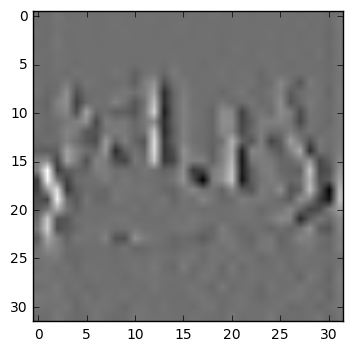

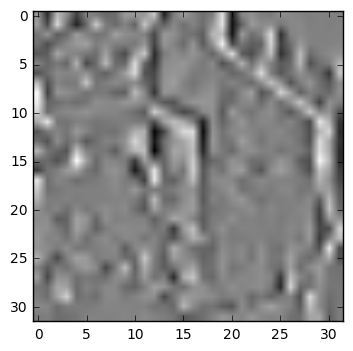

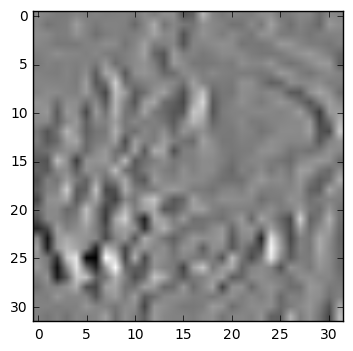

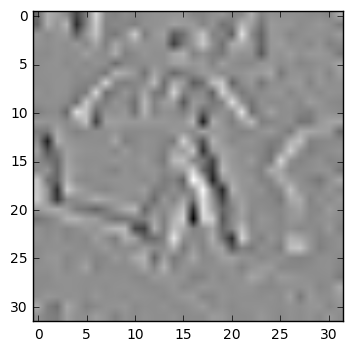

In [126]:
# plotting the results 
plot(diff_flip2)